 Copyright (c) 2015-2020, Swiss Federal Institute of Technology (ETH Zurich)

 All rights reserved.
 
 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:
 
 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
 
 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.
 
 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.
 
 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
 AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
 DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
 FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
 DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
 SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
 CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
 OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Tensorflow not available - excluding packets using it!


# Generate Experiment
1. Load the configuration and define phases and environments

In [4]:
config = TOML.load(f"configurations/examples/demo_performance_experiment_with_interference.toml")
print(TOML.dumps(config))

name = "demo_performance_with_interference"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "move"

[EXPERIMENT]
type = "PerformanceExperiment"
channel = "FlushFlushCC"

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 2e-5
delay_after_spawn = 5.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.PHASES.train]
bit_count = 150
symbol_rates = "[100, 500, 5000]"
repetitions = 2

[EXPERIMENT.PHASES.eval]
bit_count = 500
symbol_rates = "[100, 500, 5000]"
repetitions = 2

[EXPERIMENT.LAYERS.src]
name = "BitsetCoding"

[EXPERIMENT.LAYERS.lne]
name = "MultiN"

[EXPERIMENT.LAYERS.rdp]
name = "DirectActivation"

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPERIMENT.GENERAL.ARMv8]
fan = "255"
sampling_period = 0.000225

[EXPERIMENT.LAYERS.src.params]
bitset_length = 64

[EXPERIMENT.LAYERS.lne.params]
N = 64

[EXPERIMENT.LAYERS.rdp.params]

[EXPERIMENT.LAYERS.io.params]
timebase = "ns"

[ENVIRONMEN

2. Instantiate, generate and write the experiment

In [5]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()

experiment.config.experiment_exists_action = "update"
experiment.write()

2020-05-22 12:58:13 :: bootstrapped layer 'src' with BitsetCoding
2020-05-22 12:58:13 :: bootstrapped layer 'lne' with MultiN
2020-05-22 12:58:13 :: bootstrapped layer 'rdp' with DirectActivation
2020-05-22 12:58:13 :: bootstrapped layer 'io' with TimeValue
2020-05-22 12:58:13 :: symbol rates in phase 'train' given as a str, will be evaluated
2020-05-22 12:58:14 :: symbol rates in phase 'eval' given as a str, will be evaluated
2020-05-22 12:58:15 :: Estimated duration of a single repetition of the train phase is 0:00:28.036600
2020-05-22 12:58:15 :: Estimated duration of a single repetition of the eval phase is 0:00:28.097600
2020-05-22 12:58:15 :: This results in a total estimated duration of 0:01:52.268400 for all repetitions.


## Execute

Running `execute` will execute in all environments present in the configuration.

Show phases' durations.

In [6]:
experiment.print_duration()

2020-05-22 12:58:23 :: Estimated duration of a single repetition of the train phase is 0:00:28.036600
2020-05-22 12:58:23 :: Estimated duration of a single repetition of the eval phase is 0:00:28.097600
2020-05-22 12:58:23 :: This results in a total estimated duration of 0:01:52.268400 for all repetitions.


Finally, execute sequentially in all environments.

In [7]:
for env in ['ARMv8', 'Haswell']:
    experiment.execute_in_environment(env, ['train', 'eval'], resume=False)
experiment.write()

2020-05-22 13:05:29 :: executing phases: ['train', 'eval'] in env 'ARMv8'
2020-05-22 13:05:33 :: ARMv8->combined: connected: SSHUnixDriver
2020-05-22 13:05:33 :: ARMv8->combined: sending experiment
2020-05-22 13:05:34 :: ARMv8->combined: experiment sent!
2020-05-22 13:05:34 :: ARMv8->combined: configuring to {'latency': 10, 'fan': '255', 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.000225, 'delay_after_spawn': 5.0, 'delay_after_auxiliary': 1.0, 'active_wait': False, 'STANDARD': {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 2e-05, 'delay_after_spawn': 5.0, 'delay_after_auxiliary': 1.0, 'active_wait': False}}
2020-05-22 13:05:43 :: executing in env: 'ARMv8', resume: False, reps: [0, 1], run: <Run at 0x7fa3a5d20828 (digested, config={'phase': 'train', 'bit_count': 150, 'symbol_rate': 100, 'symbol_rate_id': 0, 'repetitions': 2})>
2020-05-22 13:05:43 :: executing in env: ARMv8, rep: 0, estimated duration: 0.03s, run: 

2020-05-22 13:08:57 :: executing in env: Haswell, rep: 1, estimated duration: 0.03s, run: <Run at 0x7fa3a5d20828 (digested, config={'phase': 'train', 'bit_count': 150, 'symbol_rate': 100, 'symbol_rate_id': 0, 'repetitions': 2})>
2020-05-22 13:09:09 :: Haswell->host: experiment logs fetched!
2020-05-22 13:09:09 :: executing phases: ['train', 'eval'] in env 'Haswell'
2020-05-22 13:09:09 :: Haswell->host: connected: SSHUnixDriver
2020-05-22 13:09:09 :: Haswell->host: sending experiment
2020-05-22 13:09:10 :: Haswell->host: experiment sent!
2020-05-22 13:09:10 :: executing in env: 'Haswell', resume: False, reps: [0, 1], run: <Run at 0x7fa3a5a9a1d0 (digested, config={'phase': 'train', 'bit_count': 150, 'symbol_rate': 500, 'symbol_rate_id': 1, 'repetitions': 2})>
2020-05-22 13:09:10 :: executing in env: Haswell, rep: 0, estimated duration: 0.006s, run: <Run at 0x7fa3a5a9a1d0 (digested, config={'phase': 'train', 'bit_count': 150, 'symbol_rate': 500, 'symbol_rate_id': 1, 'repetitions': 2})>
20

## Analyse

#### Deserialisation

In [10]:
path_to_serialised_experiment = PATH.Path(f"data/demo_performance_with_interference/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, diff_and_replace=False)

2020-05-22 13:14:10 :: unpicked an experiment instance <PerformanceExperiment at 0x7fa3a056d048 with FlushFlushCC channel, configured>
2020-05-22 13:14:10 :: unpickling in a dirty git repository


##### Specify the demo run and visualise

In [11]:
DEMO_PHASE = "train"
DEMO_ID = 0
DEMO_ARM = True

In [12]:
ingest_args = dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
        )
    },
    rdp={"sampling_period": experiment.environment_config_general("ARMv8")["sampling_period"]}
    if DEMO_ARM
    else {},
    io={
        "env": "ARMv8" if DEMO_ARM else "Haswell",
        "rep": 0,
        "matcher": [(exot.util.wrangle.Matcher("cache", "ff", ["access_time"], list(range(64))),None)]
    },
)

In [13]:
demo_run = experiment.phases[DEMO_PHASE][DEMO_ID]
demo_run.ingest(**ingest_args)

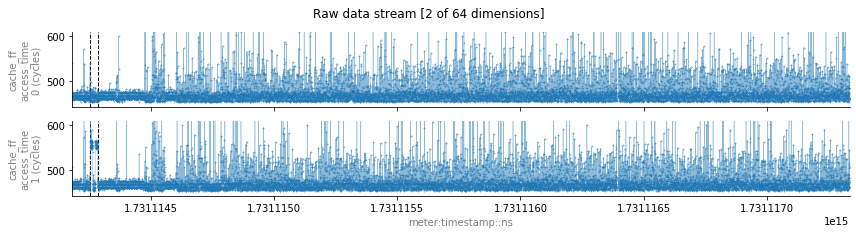

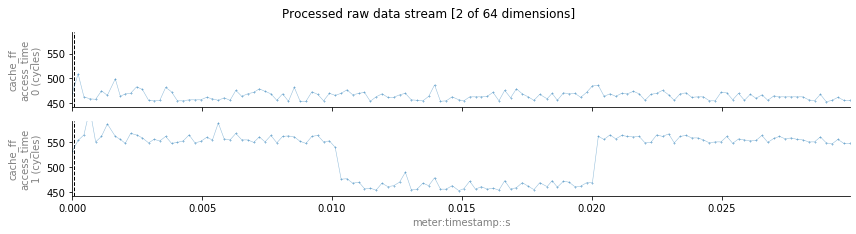

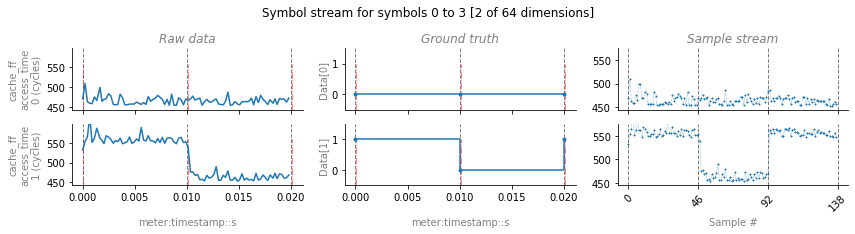

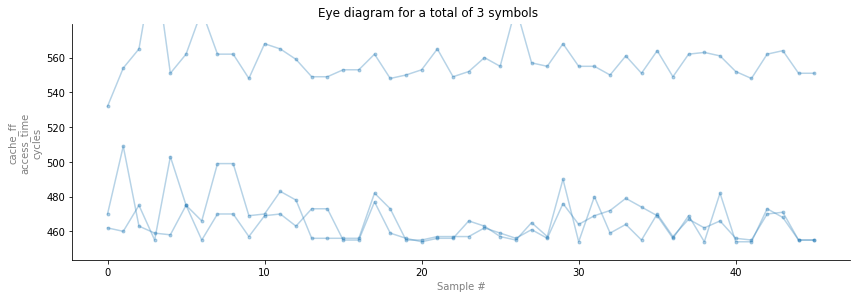

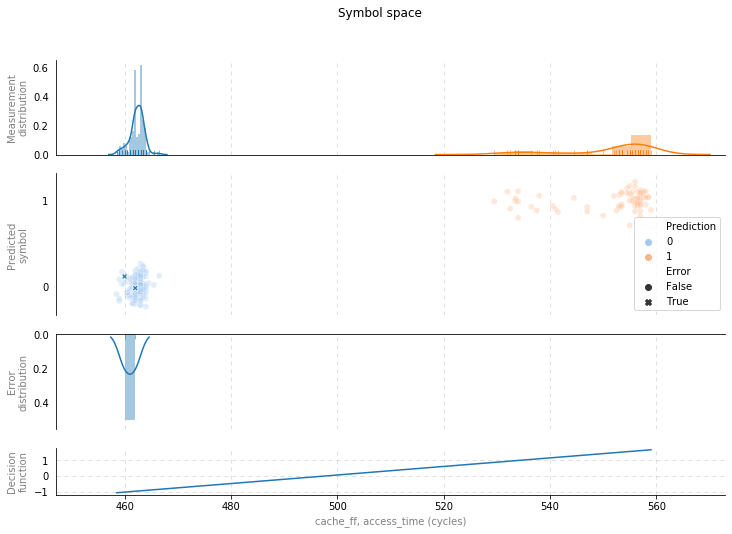

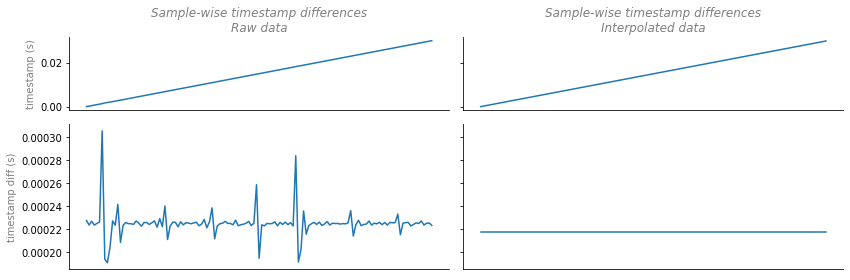

In [15]:
with PerformanceRunPlotter(demo_run) as plotter:
    plotter.plot_rawstream(dim_count=2)
    plotter.plot_rdpstream(end=5.0, dim_count=2)
    plotter.plot_slicing(dim_count=2)
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    #plotter.plot_error()
    plotter.plot_timing()

#### Analyse the experiment

_Define the analysis arguments and phase mappings_

In [17]:
analysis_args = {
    "ARMv8": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        rdp={"sampling_period": experiment.environment_config_general("ARMv8")["sampling_period"]},
        io={
            "matcher": [(exot.util.wrangle.Matcher(
                "cache", "ff", ["access_time"], list(range(64))
            ),None)]
        },
    ),
    "Haswell": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": [(exot.util.wrangle.Matcher(
                "cache", "ff", ["access_time"], list(range(64))
            ),None)]
        },
    ),
}

_Calculate the performance metrics_

In [18]:
del experiment.performance_metrics

In [20]:
for env in ['ARMv8', 'Haswell']:
    experiment.calculate_performance_metrics(
        phase_mapping=dict([tuple(["train", "eval"])]),
        envs=[env],
        reps=[],
        **analysis_args[env],
    )

2020-05-22 13:15:25 :: analysing performance for phases: train -> eval, environments ['ARMv8']
2020-05-22 13:15:37 :: analysing performance for phases: train -> eval, environments ['Haswell']


_Show the performance metrics..._

In [21]:
experiment.performance_metrics.head()

,phase,trained_with,environment,bit_rate,symbol_rate,repetition,bit_error,symbol_error,matcher,variable
0,train,,ARMv8,6400.0,100,0,0.010417,0.666667,"<Matcher quantity='cache', method='ff', values...",cache_ff
1,eval,train,ARMv8,6400.0,100,0,0.179688,0.500000,"<Matcher quantity='cache', method='ff', values...",cache_ff
2,train,,ARMv8,6400.0,100,1,0.010417,0.666667,"<Matcher quantity='cache', method='ff', values...",cache_ff
3,eval,train,ARMv8,6400.0,100,1,0.208984,0.625000,"<Matcher quantity='cache', method='ff', values...",cache_ff
4,train,,ARMv8,32000.0,500,0,0.005208,0.333333,"<Matcher quantity='cache', method='ff', values...",cache_ff


_...and the aggregated performance metrics (mean of repetitions)_

In [22]:
experiment.aggregate_performance_metrics()

,phase,trained_with,environment,bit_rate,symbol_rate,matcher,variable,bit_error,symbol_error
0,eval,train,ARMv8,6400.0,100,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.194336,0.562500
1,eval,train,ARMv8,32000.0,500,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.314453,0.750000
2,eval,train,ARMv8,320000.0,5000,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.403320,1.071429
3,eval,train,Haswell,6400.0,100,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.315848,0.928571
4,eval,train,Haswell,32000.0,500,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.174944,0.446429
5,eval,train,Haswell,320000.0,5000,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.273717,1.071429
6,train,,ARMv8,6400.0,100,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.010417,0.666667
7,train,,ARMv8,32000.0,500,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.023438,0.500000
8,train,,ARMv8,320000.0,5000,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.640625,1.500000
9,train,,Haswell,6400.0,100,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.335938,1.250000


#### Serialise the experiment with the calculated performance metrics

In [23]:
experiment.write()

##### Get aggregated performance metrics for each environment and phase and output as CSV

In [27]:
for env in ['ARMv8', 'Haswell']:
    eval_phase = 'eval'
    BERs = wrangle.filter_data(
        experiment.aggregate_performance_metrics(), environment=env, phase=eval_phase
    )
    print(env)
    print(pd.DataFrame({"bit_rate": BERs["bit_rate"], "bit_error": BERs["bit_error"]}))

ARMv8
   bit_rate  bit_error
0    6400.0   0.194336
1   32000.0   0.314453
2  320000.0   0.403320
Haswell
   bit_rate  bit_error
3    6400.0   0.315848
4   32000.0   0.174944
5  320000.0   0.273717


#### Plot performance metrics

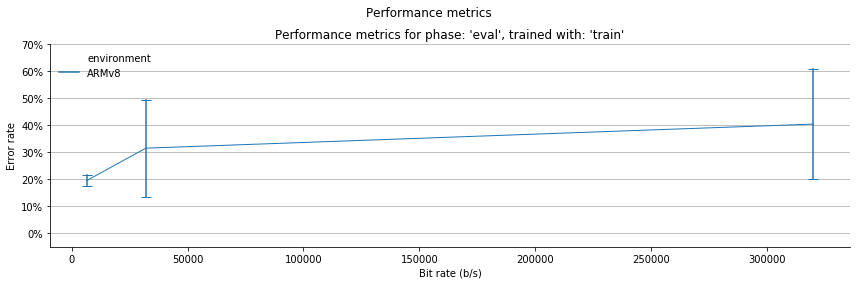

In [28]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics()